In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
from scipy.ndimage import convolve
import time
from numba import jit
from PIL import Image
import os
import ipyplot
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

2024-12-03 17:15:11.572711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Solbel filters
kernel0 = np.array([
                [-1, 0.0, 1],
                [-2, 0.0, 2],
                [-1, 0.0, 1]])
kernel1= np.array([
                [-1,-2,-1],
                [0.0,0.0,0.0],
                [1,2,1]])

# Convolution function
def convolve_img(img, kernel):
    return convolve(img, kernel)

# Flattens the image for faster processing
def brightness(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Returns partial derivative of the image
def partial_derivative(img):
    grx = convolve_img(img, kernel0)
    gry = convolve_img(img, kernel1)
    return grx, gry

# Energy function
def get_edgeness(img):
    grx, gry = partial_derivative(img)
    maxx = float('-inf')
    edged = [[ 0 for _ in range(len(grx[0]))] for _ in range(len(grx))]
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] = (abs(grx[i][j])  + abs(gry[i][j]))
    return edged

# generates the energy map from bottom to top (DP approach)
def least_edgy_ver(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img[0])):
        least_e[-1][i] = edged_img[-1][i]
    m, n = len(edged_img), len(edged_img[0])

    for i in range(m-2,-1,-1):
        for j in range(n):
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(least_e[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            least_e[i][j] = edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (j==0)]

    return least_e, dirs

# generates the energy map from left to right (DP approach)
def least_edgy_hor(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img)):
        least_e[i][-1] = edged_img[i][-1]
    m, n = len(edged_img), len(edged_img[0])
    for j in range(n-2, -1, -1):
        for i in range(m):
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(least_e[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (i==0)]
    return least_e, dirs


# Get the vertical seam
# returns an array where index is the row and value is the column
def get_seam_at_ver(dirs, j):
    m = len(dirs)
    js = [0 for _ in range(m)]
    js[0] = j
    for i in range(1, m):
        js[i] = js[i-1]+dirs[i-1][int(js[i-1])]
    return js

# Gets horizontal seam
# returns an array where index is the column and value is the row
def get_seam_at_hor(dirs, i):
    n = len(dirs[0])
    js = [0 for _ in range(n)]
    js[0] = i
    for j in range(1, n):
        js[j] = js[j-1] + dirs[int(js[j-1])][j-1]

    return js

# Shifts the image by 1 seam (removes vertical seam)
def rm_path_ver(img, path):
    img = np.array(img)
    n = len(img[0])
    cut_img = img[:, :-1].copy()

    for i, j in enumerate(path):
        j = int(j)
        cut_img[i,:j] = img[i,:j]
        cut_img[i,j:] = img[i,j+1:]

    return cut_img

# Shifts the image by 1 seam (removes horizontal seam)
def rm_path_hor(img, path):
    img = np.array(img)
    m = len(img)
    cut_img = img[:-1, :].copy()
    # print(len(cut_img), len(img))
    for i, j in enumerate(path):
        #i is col and j is row here
        j = int(j)
        cut_img[:j,i] = img[:j,i]
        cut_img[j:,i] = img[j+1:,i]

    return cut_img
# # @jit
# def shrink_horizontally(img,edged,org, n):
#     new_img = np.copy(img)
#     org_i = np.copy(org)
#     for i in range(n):  
#         dp, dirs = least_edgy_ver(edged)
#         m_col = float('inf')
#         col = 0
#         for j in range(0,len(dp[0])):
#             if m_col > dp[0][j]:
#                 m_col = dp[0][j]
#                 col = j 
#         seam = get_seam_at_ver(dirs, col)
#         new_img = rm_path_ver(new_img, seam)
#         org_i = rm_path_ver(org_i, seam)
#         edged = rm_path_ver(edged, seam)

#     return new_img, org_i
# # @jit
# def shrink_vertically(img,edged,org, n):
#     new_img = np.copy(img)
#     org_i = np.copy(org)
#     for i in range(n):
#         dp, dirs = least_edgy_hor(edged)
#         m_row = float('inf')
#         row = 0
#         for j in range(0,len(dp)):
#             if m_row > dp[j][0]:
#                 m_row = dp[j][0]
#                 row = j
#         seam = get_seam_at_hor(dirs, row)
#         new_img = rm_path_hor(new_img, seam)
#         org_i = rm_path_ver(org_i, seam)
#         edged = rm_path_hor(edged, seam)

#     return new_img, org_i

'''
# Goes through every adjecent pixels of the vertical seam
# Updating all energy map and the optimal seam directions.
# This is our optimized apprach which run as opposed to regenrating th energy map after every seam removal
# This apprach work well for images with high and dispersed average while for low/concentrated energy maps, this methods 
# tends to loose its features
'''
def recompute_dir_neighbours_ver(seam, dirs, dp, edged_img):
    m = len(dp)
    n = len(dp[0])
    for i in range(len(seam)-2, -1,-1):
        j = int(seam[i])
        if j == 0:
            # If we removed 0 column then we have to update 0 column
            j1, j2 = 0, 1
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
                
            dp[i][0] += edged_img[i][0]+min_e
            dirs[i][0] = (0,1)[direction]
        elif j == n:
            j = j-1
            # If we removed n-1 column then we have to update n-1 column
            j1, j2 = j-1, j
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1, 0)[direction]
        else:
            if j-1>=0:
                j1, j2 = max(0, j-2), min(j, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j-1] += edged_img[i][j-1] + min_e
                dirs[i][j-1] = (-1,0,1)[direction + ((j-1)==0)]
            if j<n-1:
                j1, j2 = max(0, j-1), min(j+1, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j] += edged_img[i][j] + min_e
                dirs[i][j] = (-1,0,1)[direction + (j==0)]
            
            
    return dp, dirs

'''
# Goes through every adjecent pixels of the horizontal seam
# Updating all energy map and the optimal seam directions.
# This is our optimized apprach which run as opposed to regenrating th energy map after every seam removal
# This apprach work well for images with high and dispersed average while for low/concentrated energy maps, this methods 
# tends to loose its features
'''
def recompute_dir_neighbours_hor(seam, dirs, dp, edged):
    m = len(dirs)
    n = len(dirs[0])
    for j in range(len(seam)-2,-1,-1):
        i = int(seam[j])
        if i == 0:
            i1, i2 = 0, 1
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[0][j] += edged[0][j] + min_e
            dirs[0][j] = (0,1)[direction]
        elif i == m:
            i = i-1
            i1, i2 = i-1, i
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0)[direction]
        else:
            i1, i2 = max(0, i-2), min(i, m-1)
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i-1][j] += edged[i-1][j] + min_e
            dirs[i-1][j] = (-1,0,1)[direction+((i-1)==0)]
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction+(i==0)]
        
    return dp, dirs

'''
This function removes vertical seams, shrinking the image horizontally
'''
def shrink_horizontally(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    new_edged = np.copy(edged)
    dp, dirs = least_edgy_ver(edged)
    rev = False
    for i in range(n):  
        start = 0
        end = len(dp[0])
        step = 1
        if rev == False:
            rev = True
        elif rev == True:
            rev = False
            start = len(dp[0])-1
            end = -1
            step = -1
            
        m_col = float('inf')
        col = 0
        for j in range(start, end, step):
            if m_col > dp[0][j]:
                m_col = dp[0][j]
                col = j 
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        org_img = rm_path_ver(org_img, seam)
        dp = rm_path_ver(dp, seam)
        dirs = rm_path_ver(dirs, seam)
        # edged = get_edgeness(new_img)
        new_edged = rm_path_ver(new_edged, seam)
        dp, dirs = recompute_dir_neighbours_ver(seam,dirs,dp,new_edged)

    return new_img, org_img


'''
This function removes horizontal seams, shrinking the image vertically
'''
def shrink_vertically(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_hor(edged)
    rev = False
    for i in range(n):
        start = 0
        end = len(dp)
        step = 1
        if rev == False:
            rev = True
        elif rev == True:
            rev = False
            start = len(dp)-1
            end = -1
            step = -1
            
        m_row = float('inf')
        row = 0
        for j in range(start, end, step):
            if m_row > dp[j][0]:
                m_row = dp[j][0]
                row = j 
        seam = get_seam_at_hor(dirs, row)
        new_img = rm_path_hor(new_img, seam)
        org_img = rm_path_hor(org_img, seam)
        dp = rm_path_hor(dp, seam)
        dirs = rm_path_hor(dirs, seam)
        edged = rm_path_hor(edged, seam)
        dp, dirs = recompute_dir_neighbours_hor(seam, dirs, dp, edged)

    return new_img, org_img

(533, 800, 3)


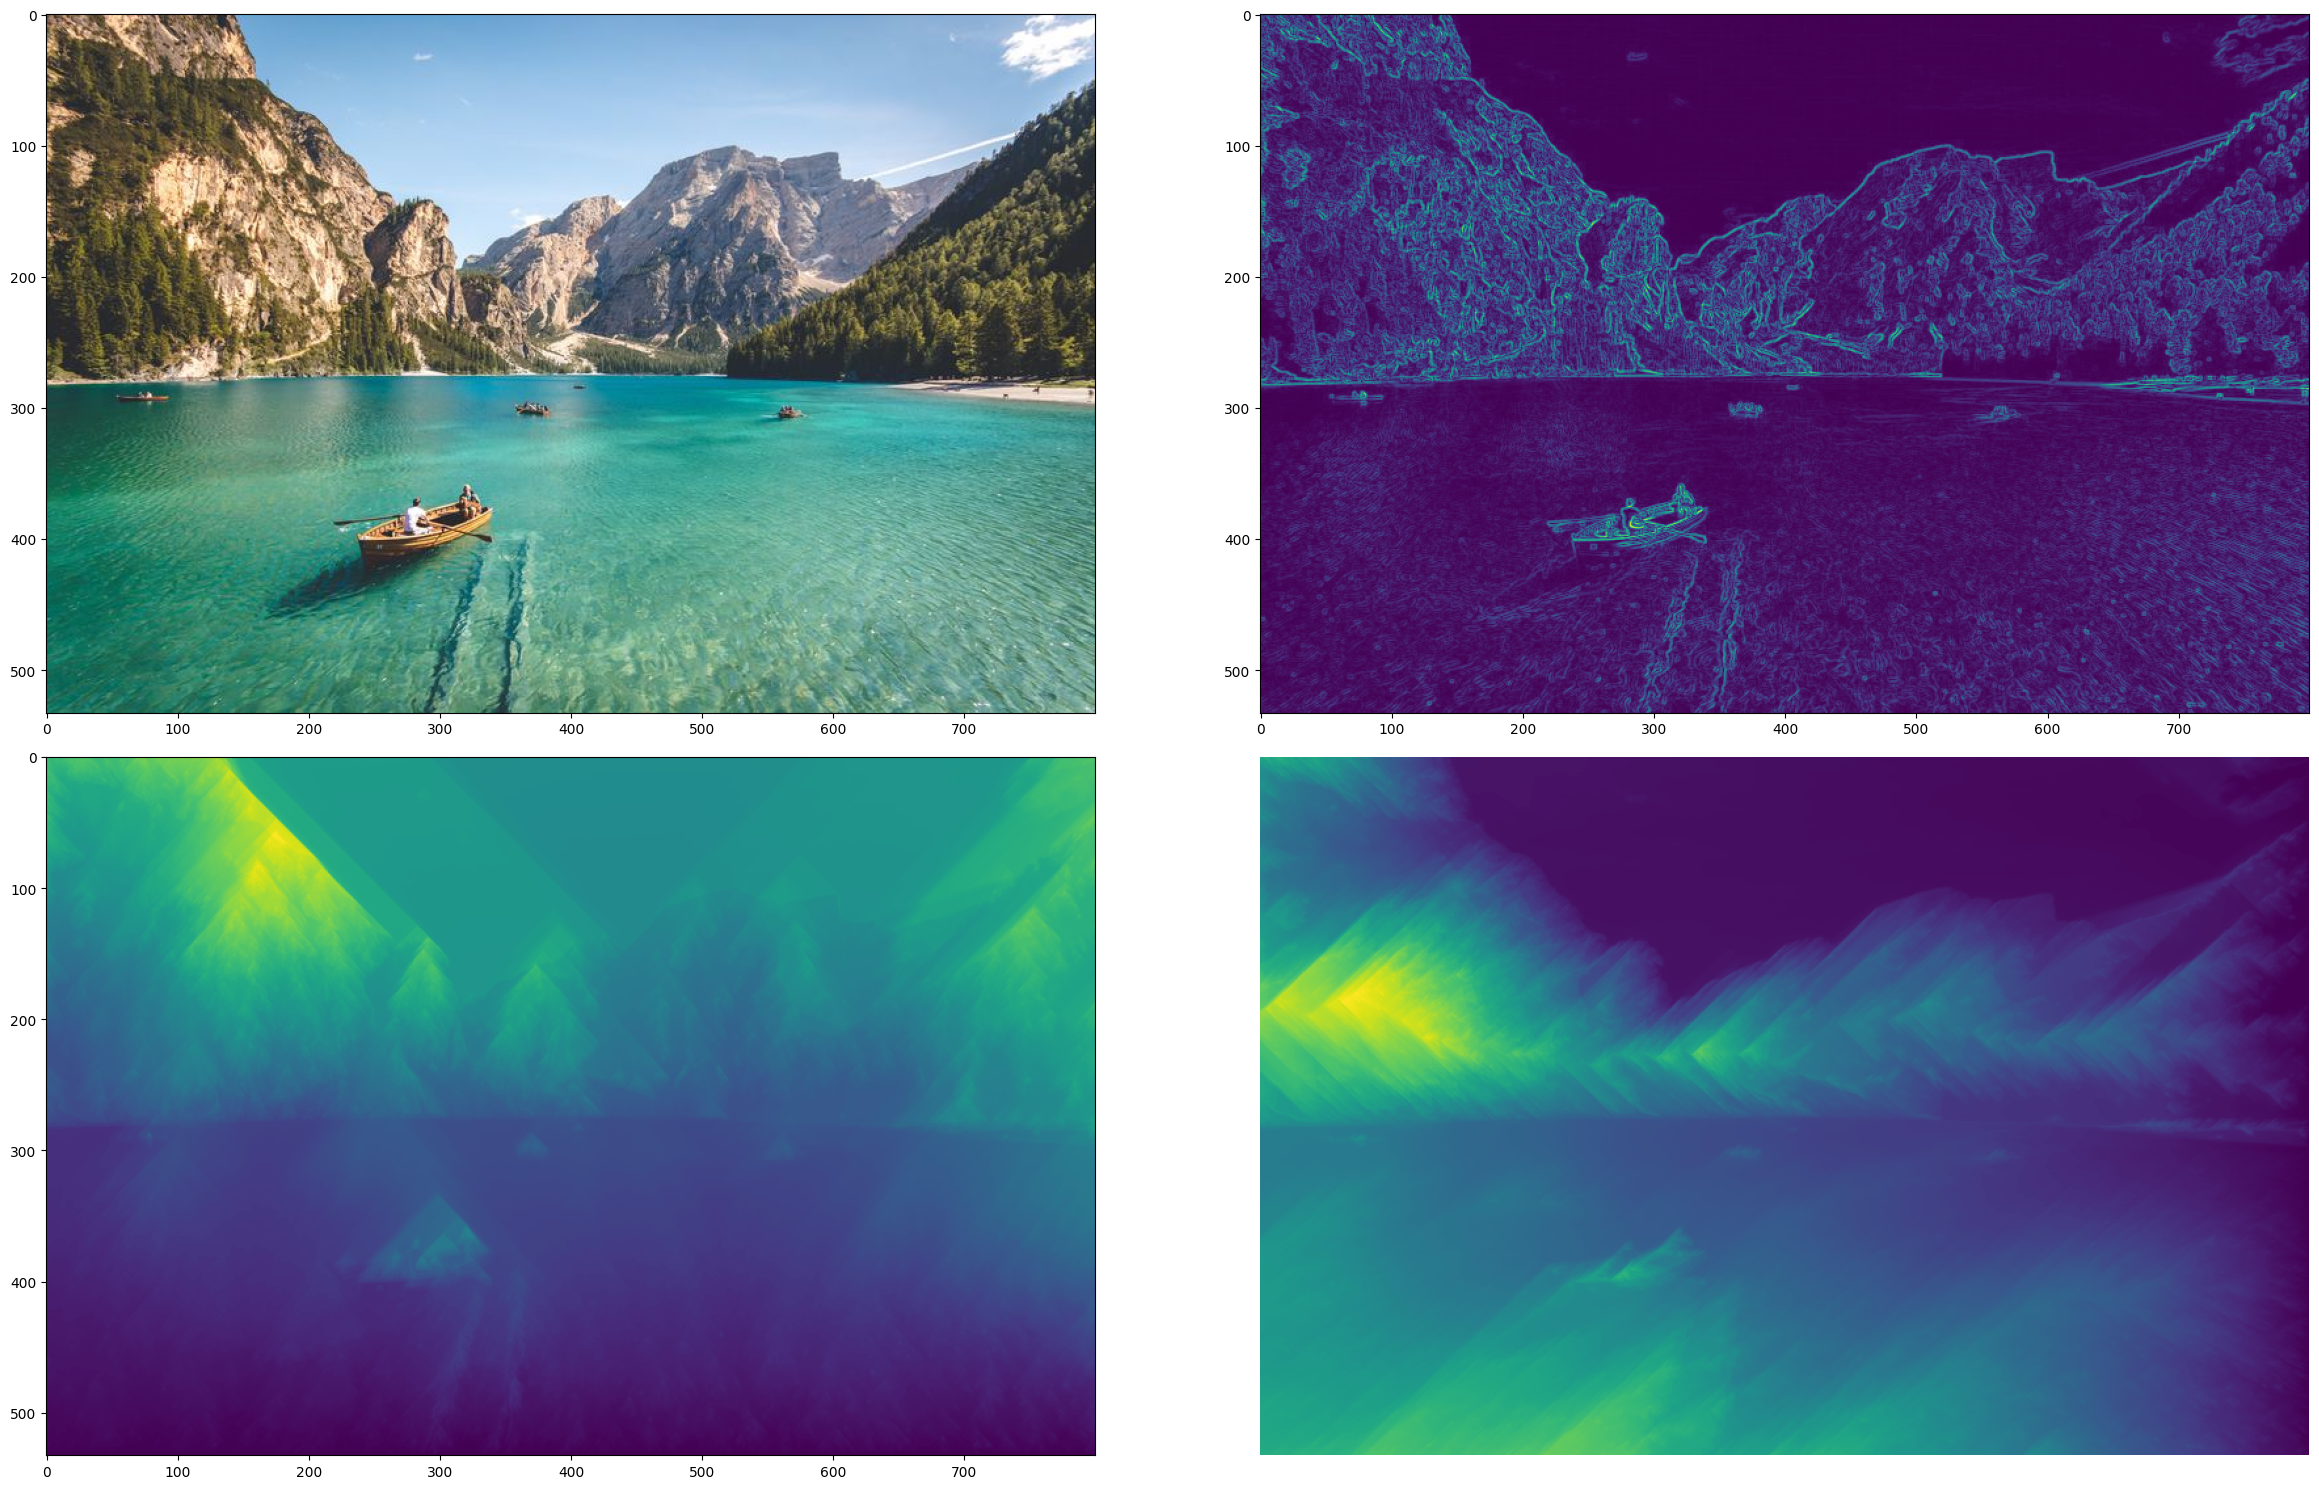

In [3]:
# imgorg = Image.open('../Cars/Original/00010.jpg')
imgorg = Image.open('img6.jpg')
imgorg = np.array(imgorg)
print(imgorg.shape)
img = brightness(imgorg)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
edged = get_edgeness(img)
dp1, dirs1 = least_edgy_ver(edged)
dp2, dirs2 = least_edgy_hor(edged)
axes[0][0].imshow(imgorg)
axes[0][1].imshow(edged)
axes[1][0].imshow(dp1)
axes[1][1].imshow(dp2)
plt.axis('off')
plt.tight_layout()

It took 11s to shrink horizontally by 240px and vertically by 160px


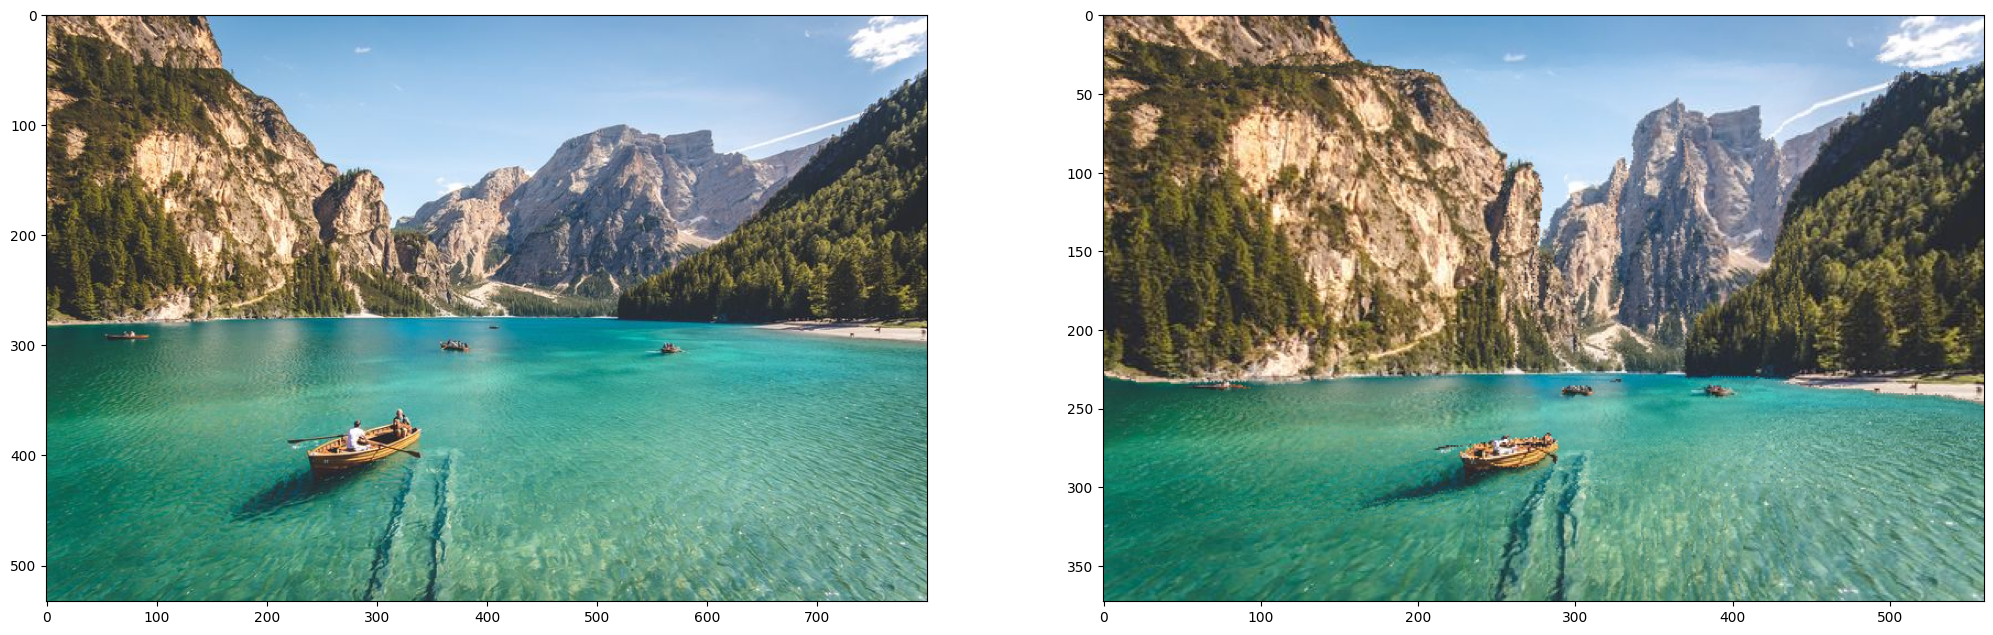

In [4]:
scale = 0.3
horPx = round(img.shape[1] * scale)
verPx = round(img.shape[0] * scale)
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
edged = get_edgeness(img)
img1 = shrink_horizontally(img,edged,imgorg,horPx)
edged = get_edgeness(img1[0])
img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
img_from_array = Image.fromarray(img2[1])
img_from_array.save("new_image.jpg")
axes[0].imshow(imgorg)
axes[1].imshow(img2[1])
end = time.time()
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")

In [7]:
df = pd.read_csv('../Cars/stanford_cars_with_class_names - test.csv',header=0,encoding='utf-8')
df.head(5)
df = df[df['class'].isin([7,8,9,11,12,13,14])]
df.head()

x1   y1    x2    y2  class           ture_class_name        image
245   73  421  1525  1114      7  Acura ZDX Hatchback 2012  '00036.jpg'
246   38  114   619   345      7  Acura ZDX Hatchback 2012  '00085.jpg'
247  112   30   486   329      7  Acura ZDX Hatchback 2012  '00251.jpg'
248   55  104   591   386      7  Acura ZDX Hatchback 2012  '00497.jpg'
249   16   95   636   383      7  Acura ZDX Hatchback 2012  '00976.jpg'

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
count = 0
path = '../Cars/Original/cars_test/'
savePath = '../Cars/Resized/Test/'
logfile = ""
start = time.time() 
# for file in os.listdir(path):
for file in df['image']:
    if len(file.split(('\'')) >= 3:
        file = file.split('\'')[1]
    if file.split('.')[-1] != 'jpg':
        continue
    print("Processing file "+str(count+1)+":"+file)
    imgorg = Image.open(path+file)
    imgorg = np.array(imgorg)
    if len(imgorg.shape) <= 2:
        print("Image too small to process: "+file)
        logfile += "Image too small to process: "+file+"\n"
        count += 1
        continue
    if imgorg.shape[0] <= 224 or imgorg.shape[0] <= 224:
        final = np.transpose(processor(imgorg, do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
        img_from_array = Image.fromarray(final.astype(np.uint8))
        img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
        logfile += "Image only BIL: "+file+"\n"
        count += 1
        continue
    img = brightness(imgorg)
    scale = 0.3
    horPx = round(img.shape[1] * scale)
    verPx = round(img.shape[0] * scale)
    edged = get_edgeness(img)
    img1 = shrink_horizontally(img,edged,imgorg,horPx)
    edged = get_edgeness(img1[0])
    img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
    final = np.transpose(processor(img2[1], do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
    img_from_array = Image.fromarray(final.astype(np.uint8))
    img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
    count += 1
end = time.time()

print("Time taken to process "+str(count + 1)+" images ~ "+str(round((end-start)/60))+" mins")

Processing file 1:00036.jpg
Processing file 2:00085.jpg
Processing file 3:00251.jpg
Processing file 4:00497.jpg
Processing file 5:00976.jpg
Processing file 6:00991.jpg
Processing file 7:01274.jpg
Processing file 8:01276.jpg
Processing file 9:01291.jpg
Processing file 10:01429.jpg
Processing file 11:01709.jpg
Processing file 12:01731.jpg
Processing file 13:01815.jpg
Processing file 14:01952.jpg
Processing file 15:02050.jpg
Processing file 16:02426.jpg
Processing file 17:02436.jpg
Processing file 18:02688.jpg
Processing file 19:02899.jpg
Processing file 20:02944.jpg
Processing file 21:03059.jpg
Processing file 22:04517.jpg
Processing file 23:04583.jpg
Processing file 24:04641.jpg
Processing file 25:04856.jpg
Processing file 26:05110.jpg
Processing file 27:05550.jpg
Processing file 28:05627.jpg
Processing file 29:05991.jpg
Processing file 30:06209.jpg
Processing file 31:06216.jpg
Processing file 32:06773.jpg


In [ ]:
# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
# data1 = {"labels":[10, 15, 20, 30, 40, 50], "images":[]}
# for per in data1["labels"]:
#     scale = per/100
#     horPx = round(img.shape[1] * scale)
#     verPx = round(img.shape[0] * scale)
#     edged = get_edgeness(img)
#     img1 = shrink_horizontally(img,edged,imgorg,horPx)
#     edged = get_edgeness(img1[0])
#     img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
#     # final = np.transpose(processor(img2[1],do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
#     img_from_array = Image.fromarray(img2[1])
#     img_from_array.save("img_"+str(per)+"_sc.jpg")
#     data1["images"].append(final)
# fig, axes = plt.subplots(3, 2, figsize=(25, 25))
# axes[0][0].imshow(data1["images"][0])
# axes[0][0].set_title(data1["labels"][0])
# axes[0][1].imshow(data1["images"][1])
# axes[0][1].set_title(data1["labels"][1])
# axes[1][0].imshow(data1["images"][2])
# axes[1][0].set_title(data1["labels"][2])
# axes[1][1].imshow(data1["images"][3])
# axes[1][1].set_title(data1["labels"][3])
# axes[2][0].imshow(data1["images"][4])
# axes[2][0].set_title(data1["labels"][4])
# axes[2][1].imshow(data1["images"][5])
# axes[2][1].set_title(data1["labels"][5])